 <h1 style="text-align: center; font-size: 50px;font-weight: bold;"> Bayesian Machine Learning
   </h1>


 <h1 style="text-align: center; font-size: 25px;font-weight: bold;"> Project : Computing Nonvacuous Generalization Bounds for Deep (Stochastic) Neural
 Networks with Many More Parameters than Training Data </h1>


In [1]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.init as init
import numpy as np
import torch.optim as optim

import math
import time as ts

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
# Download and load the dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# train_dataset = torch.utils.data.Subset(train_dataset, range(55000))
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [3]:
print(train_dataset)
print(test_dataset)

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False)

# Get a batch of images and labels
images, labels = next(iter(train_loader))

In [5]:
print(images.shape, labels.shape)

torch.Size([100, 1, 28, 28]) torch.Size([100])


tensor(-0.0840) tensor(2.8215) tensor(-0.4242)


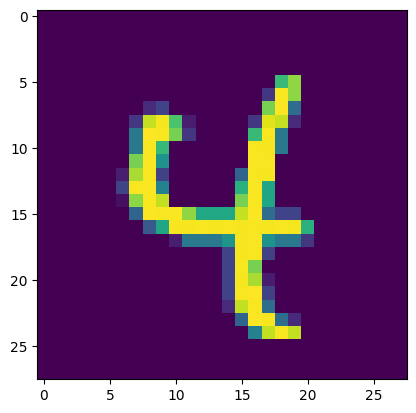

In [6]:
plt.imshow(images[0,0,:,:])
print(torch.mean(images[0,0,:,:]), torch.max(images[0,0,:,:]), torch.min(images[0,0,:,:]))

In [7]:
class MLP(nn.Module):
    def __init__(self, nb_nodes, nb_hidden_layers, classes=1):
        super().__init__()

        layers = [torch.nn.Flatten(), nn.Linear(28 * 28, nb_nodes), nn.ReLU()]

        for _ in range(nb_hidden_layers - 1):
            layers.append(nn.Linear(nb_nodes, nb_nodes))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(p=0.4))

        layers.append(nn.Linear(nb_nodes, classes))

        self.layers = nn.Sequential(*layers)

        self.initialize_weights()   # Initialize weights after layer creation

    def forward(self, input):
        x = torch.flatten(input, start_dim=1)
        x = self.layers(x)
        return x

    def truncated_normal_(self, tensor, mean=0, std=0.04, low=-2, high=2):
        """Truncated normal initialization for weights."""
        with torch.no_grad():
            tensor.normal_(mean, std)
            tensor.clamp_(low*std, high*std)  # Truncate values to [-2*sigma, 2*sigma]

    def initialize_weights(self):
        """Initialize weights and biases as per the given specifications."""
        linear_layer = 0
        for  m in self.modules():
            if isinstance(m, nn.Linear):
                self.truncated_normal_(m.weight, mean=0, std=0.04, low=-2, high=2)
                
                if linear_layer == 0:  # First layer after input
                    init.constant_(m.bias, 0.1)
                else:
                    init.constant_(m.bias, 0)
                linear_layer +=1

In [8]:
lr = 0.0001
epochs = 200
patience = 20

In [9]:
import copy
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = MLP(nb_nodes=600, nb_hidden_layers=2).to(device)
model = MLP(nb_nodes=600, nb_hidden_layers=1).to(device)
print(model)

# optimizer = torch.optim.RMSprop(model.parameters(), lr = lr, momentum=0.9, eps=1e-5)
# optimizer = torch.optim.Adam(model.parameters(), lr = lr)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

MLP(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=600, bias=True)
    (2): ReLU()
    (3): Linear(in_features=600, out_features=1, bias=True)
  )
)


In [10]:
def print_weights_and_biases(model):
    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"Layer: {name} | Weights:\n{param.data}\n")
        elif "bias" in name:
            print(f"Layer: {name} | Biases:\n{param.data}\n")

# print_weights_and_biases(model)


In [11]:
import torch.nn.functional as F

def plot_training_history(history_train_loss, history_val_loss):
    epochs = range(1, len(history_train_loss) + 1)

    # figure avec deux sous-graphes côte à côte
    plt.figure(figsize=(14, 5))

    # Graphique pour la perte
    plt.semilogy(epochs, history_train_loss, label='Train Loss', marker='o')
    plt.semilogy(epochs, history_val_loss, label='Validation Loss', marker='o')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def label_modif(label):
    """ Changes the labels of the MNIST dataset to transform it into a binary
    classification problem by mapping numbers {0,.....,4} to label 1 and {5,......,9} to label -1"""
    # print("label check before", label)
    label[label<=4] = 1
    label[label >=5] = -1
    # print("label check after", label)
    
    return label

def logistic_loss(labels, outputs):
    loss = (1/(np.log(2)))*torch.log(1+torch.exp(-labels*outputs))
    return torch.mean(loss)


def training_pipeline(epochs, model, train_loader, test_loader, optimizer, patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_train_tab = []
    loss_valid_tab = []
    best_val_loss = float("inf")
    best_model = None
    model.to(device)
    print("Module sélectionné pour l'entraînement :", device)
    epochs_no_improve = 0
    
    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0
        
        for k, (image_train, label_train) in enumerate(train_loader):
            label_train = label_modif(label_train)
            image_train, label_train = image_train.to(device), label_train.to(device).float()
            optimizer.zero_grad()
            output = model(image_train)
            loss = logistic_loss(label_train, output.squeeze(1))
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            # Prediction: sign of output as predicted label (assumes output is a real number)
            predictions = torch.sign(output.squeeze(1))
            total_train_correct += (predictions == label_train).sum().item()
            total_train_samples += label_train.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train_samples
        loss_train_tab.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0
        with torch.no_grad():
            for k, (image_test, label_test) in enumerate(test_loader):
                label_test = label_modif(label_test)
                image_test, label_test = image_test.to(device), label_test.to(device).float()
                output = model(image_test)
                loss = logistic_loss(label_test, output.squeeze(1))
                total_val_loss += loss.item()
                predictions = torch.sign(output.squeeze(1))
                total_val_correct += (predictions == label_test).sum().item()
                total_val_samples += label_test.size(0)
        avg_val_loss = total_val_loss / len(test_loader)
        val_accuracy = total_val_correct / total_val_samples
        loss_valid_tab.append(avg_val_loss)
        
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model)  # Sauvegarde du meilleur modèle
            epochs_no_improve = 0  # Reset du compteur
            print(f"A new best model has been found with validation loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break
        
        if (epoch + 1) % 10 == 0:
            plot_training_history(loss_train_tab, loss_valid_tab)
            
    plot_training_history(loss_train_tab, loss_valid_tab)
    return best_model, loss_valid_tab

        

Module sélectionné pour l'entraînement : cuda
Epoch 1/20 - Train Loss: 0.2142, Validation Loss: 0.1291, Train Acc: 0.9437, Val Acc: 0.9692
A new best model has been found with validation loss: 0.1291
Epoch 2/20 - Train Loss: 0.0994, Validation Loss: 0.1204, Train Acc: 0.9761, Val Acc: 0.9713
A new best model has been found with validation loss: 0.1204
Epoch 3/20 - Train Loss: 0.0722, Validation Loss: 0.1002, Train Acc: 0.9827, Val Acc: 0.9756
A new best model has been found with validation loss: 0.1002
Epoch 4/20 - Train Loss: 0.0537, Validation Loss: 0.0826, Train Acc: 0.9873, Val Acc: 0.9803
A new best model has been found with validation loss: 0.0826
Epoch 5/20 - Train Loss: 0.0421, Validation Loss: 0.0906, Train Acc: 0.9907, Val Acc: 0.9787
Epoch 6/20 - Train Loss: 0.0325, Validation Loss: 0.0848, Train Acc: 0.9931, Val Acc: 0.9810
Epoch 7/20 - Train Loss: 0.0254, Validation Loss: 0.0832, Train Acc: 0.9950, Val Acc: 0.9817
Epoch 8/20 - Train Loss: 0.0193, Validation Loss: 0.0872, T

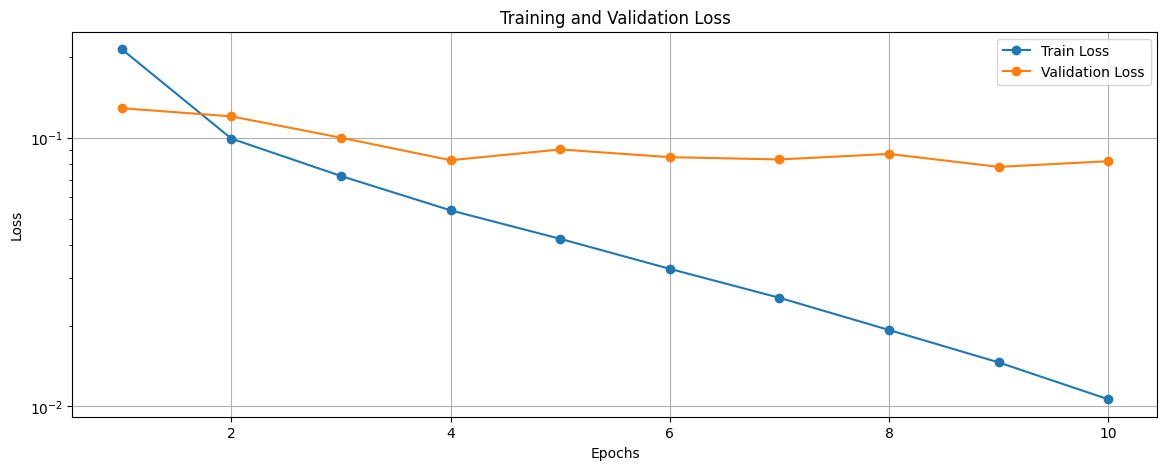

Epoch 11/20 - Train Loss: 0.0083, Validation Loss: 0.0819, Train Acc: 0.9992, Val Acc: 0.9826
Epoch 12/20 - Train Loss: 0.0063, Validation Loss: 0.0827, Train Acc: 0.9997, Val Acc: 0.9826
Epoch 13/20 - Train Loss: 0.0052, Validation Loss: 0.0847, Train Acc: 0.9998, Val Acc: 0.9832
Epoch 14/20 - Train Loss: 0.0042, Validation Loss: 0.0831, Train Acc: 0.9999, Val Acc: 0.9837
Epoch 15/20 - Train Loss: 0.0035, Validation Loss: 0.0838, Train Acc: 0.9999, Val Acc: 0.9841
Epoch 16/20 - Train Loss: 0.0029, Validation Loss: 0.0858, Train Acc: 1.0000, Val Acc: 0.9840
Epoch 17/20 - Train Loss: 0.0026, Validation Loss: 0.0885, Train Acc: 1.0000, Val Acc: 0.9833
Epoch 18/20 - Train Loss: 0.0023, Validation Loss: 0.0880, Train Acc: 1.0000, Val Acc: 0.9834
Epoch 19/20 - Train Loss: 0.0020, Validation Loss: 0.0875, Train Acc: 1.0000, Val Acc: 0.9837
Epoch 20/20 - Train Loss: 0.0018, Validation Loss: 0.0876, Train Acc: 1.0000, Val Acc: 0.9838


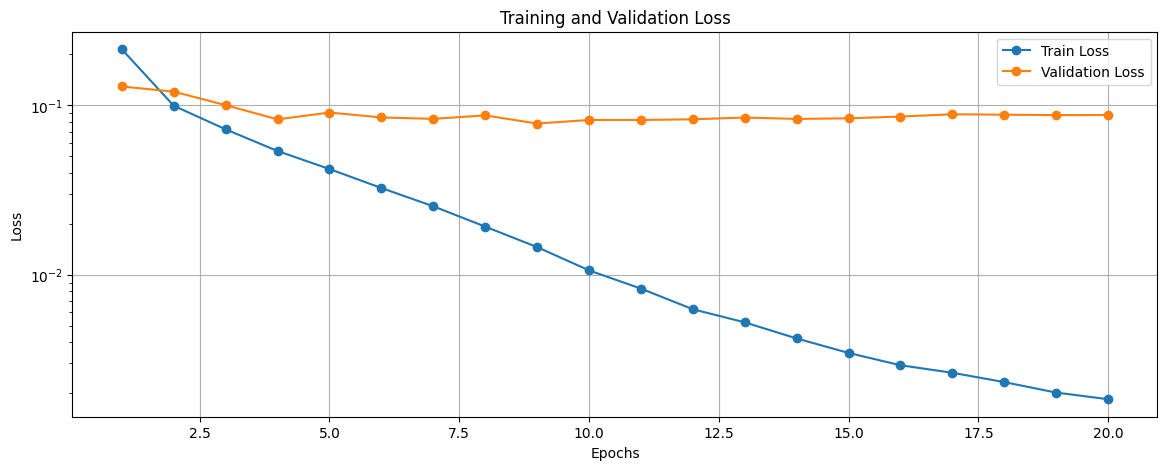

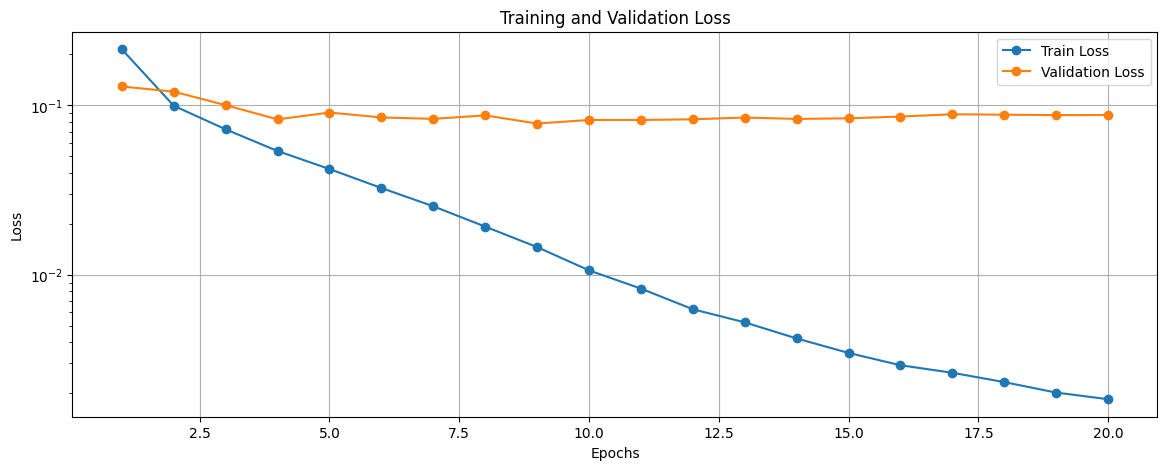

In [12]:
best_model, loss_validation = training_pipeline(epochs=20, model=model, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer, patience=patience)

# PAC BOUND

In [12]:
# Stochastic Linear Layer

class StochLinear(torch.nn.Module):
    def __init__(self, in_features, out_features, bias=True, 
                 init_inv_softplus_sigma=-3.0, eps=1e-6):
        super().__init__()
        self.weight_mu = torch.nn.Parameter(torch.zeros(out_features, in_features))
        self.weight_ispsigma = torch.nn.Parameter(torch.empty(out_features, in_features).fill_(
                                                                                init_inv_softplus_sigma))
        if bias:
            self.bias_mu = torch.nn.Parameter(torch.zeros(out_features))
            self.bias_ispsigma = torch.nn.Parameter(torch.empty(out_features).fill_(init_inv_softplus_sigma))
        self.eps = eps
        self.with_bias = bias
    
    
    def forward(self, x):
        weight = self.weight_mu + torch.randn_like(self.weight_mu) * self.weight_sigma
        if self.with_bias:
            bias = self.bias_mu + torch.randn_like(self.bias_mu) * self.bias_sigma
        else:
            bias = None
        return torch.nn.functional.linear(x, weight, bias)
    
    def copy_weights(self, linear_layer):
        self.weight_mu.detach().copy_(linear_layer.weight)
        if self.with_bias:
            self.bias_mu.detach().copy_(linear_layer.bias)
            
    @property
    def weight_sigma(self):
        return torch.nn.functional.softplus(self.weight_ispsigma) + self.eps
    
    @property
    def bias_sigma(self):
        return torch.nn.functional.softplus(self.bias_ispsigma) + self.eps
            

In [13]:
# Stochastic Neural Network

class StochaNN(nn.Module):
    def __init__(self, nb_nodes, nb_hidden_layers, classes=1, isp_sigma=-3.0):
        super().__init__()

        layers = [torch.nn.Flatten(), StochLinear(28 * 28, nb_nodes, init_inv_softplus_sigma=isp_sigma), nn.ReLU()]

        for _ in range(nb_hidden_layers - 1):
            layers.append(StochLinear(28**2, 600, init_inv_softplus_sigma=isp_sigma))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(p=0.4))

        layers.append(StochLinear(nb_nodes, classes, init_inv_softplus_sigma=isp_sigma))

        self.layers = nn.Sequential(*layers)

    def forward(self, input):
        return self.layers(input)

In [14]:
# Approximate PAC-Bayes bound

def kl_bernoulli(q, p):
    return q * math.log(q / p)+ (1 - q) * math.log((1 - q) / (1 - p))
    
def get_approx_bound(b_re, acc, res=1000):
    ts = np.linspace(0, 1., res)
    kls = [kl_bernoulli(1 - acc, t) for t in ts]
    idx = np.argmin(np.abs(np.array(kls) - b_re))
    return ts[idx]

# Training
def train_epoch(loader, model, loss_fn, optimizer, device=device):
    """
    Runs one training epoch.
    """
    model.train()
    running_loss = 0.0
    total_samples = 0
    total_train_samples = 0
    total_train_correct = 0
    acc = 0

    
    for i, (inputs, targets) in enumerate(loader):
    
        inputs = inputs.to(device)
        targets = label_modif(targets)
        targets = targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss, _, _ = loss_fn(model, inputs, targets)
        # print(loss)
        loss.backward()
        optimizer.step()
        
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size
        total_train_samples += batch_size
        predictions = torch.sign(outputs.squeeze(1))
        total_train_correct += (predictions == targets).sum().item()

        total_train_samples += 1
    acc = acc / len(loader)
    avg_loss = running_loss / total_samples
    train_accuracy = total_train_correct / total_train_samples
    
    return {"loss": avg_loss, "stats": {'accuracy': train_accuracy}}


def eval_model(loader, model, loss_fn, device=device):
    """
    Evaluates the model on the given dataset.
    """
    model.eval()
    running_loss = 0.0
    total_samples = 0
    total_correct = 0
    acc = 0
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs = inputs.to(device)
            targets = label_modif(targets)
            targets = targets.to(device).float()
            outputs = model(inputs)
            loss, _, _ = loss_fn(model, inputs, targets)
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size
            predictions = torch.sign(outputs.squeeze(1))
            total_correct += (predictions == targets).sum().item()
        
        acc = acc / len(loader)
        avg_loss = running_loss / total_samples
        accuracy = total_correct / total_samples
    return {"loss": avg_loss, "stats": {'accuracy': accuracy}}


In [15]:
class PACBound:
    def __init__(self, prior_mean, lambda_init, likelihood_fn, num_data, delta=0.025, b=100, c=0.1):
        
        self.prior_mu = prior_mean.to(device)
        self.log_lambda_ = torch.tensor([math.log(lambda_init)],
                                   requires_grad=True, device=device)
        self.likelihood_fn = likelihood_fn
        self.num_data = torch.tensor([num_data], requires_grad=False, 
                                     dtype=float, device=device)
        self.delta = delta
        self.b = b
        self.c = c
        
    def kl(self, stoch_network):
        mu_net, sigma_net = self._get_mu_sigma(stoch_network.layers)
        prior_sigma = torch.ones_like(sigma_net, device=sigma_net.device) * self.prior_sigma.cuda()

        return self._kl_gaussians(mu_net, sigma_net, self.prior_mu, prior_sigma)
    
    def train_bound(self, stoch_network, x, y):
        preds = stoch_network(x).flatten()
        acc = (preds * y > 0).float().mean()
        likelihood = self.likelihood_fn(preds, y)
        regularizer =  torch.sqrt(self.B_RE(stoch_network) / 2)
        # print(likelihood, regularizer)
        return likelihood + regularizer, preds, \
               {'accuracy': acc, 'regularizer': regularizer}
        
    def B_RE(self, stoch_network):
        kl = self.kl(stoch_network)
        return (kl + 
                2 * torch.log(torch.abs(self.b * (math.log(self.c) - self.log_lambda_))) + 
                math.log(math.pi**2 * self.num_data / (6 * self.delta))) / (self.num_data - 1)
        
    @property
    def prior_sigma(self):
        return 1 / torch.sqrt(torch.exp(self.log_lambda_))
        
    @staticmethod
    def _kl_gaussians(mu_1, sigma_1, mu_2, sigma_2):
        device = mu_1.device

        mu_1 = mu_1.to(device)
        mu_2 = mu_2.to(device)
        sigma_1 = sigma_1.to(device)
        sigma_2 = sigma_2.to(device)
        
        d = mu_1.numel()
        kl = 0.5 * (torch.sum(torch.log(sigma_2) - torch.log(sigma_1)) * 2 +
                    torch.sum(sigma_1**2 / sigma_2**2) +
                    torch.sum((mu_2 - mu_1)**2 / sigma_2**2) - d)
        return kl 
        
    @staticmethod
    def _get_mu_sigma(stoch_network):
        mu_net, sigma_net = [torch.cat(a) for a in 
                             zip(*[
                                  [torch.cat([layer.weight_mu.flatten(), layer.bias_mu.flatten()]),
                                  torch.cat([layer.weight_sigma.flatten(), layer.bias_sigma.flatten()])]
                                  for 
                                  layer in stoch_network if
                                  isinstance(layer, StochLinear)])
                            ]
        return mu_net, sigma_net

In [21]:
model = MLP(nb_nodes=600, nb_hidden_layers=1)
state_dict = torch.load("model_init.pt")
model.load_state_dict(state_dict)
model.cuda()

prior_mu = torch.cat([p.detach().flatten() for p in model.layers.parameters()])
pac_bound = PACBound(prior_mu, lambda_init=1e-3, likelihood_fn=logistic_loss, num_data=len(train_dataset))

stoch_model = StochaNN(nb_nodes=600, nb_hidden_layers=1, isp_sigma=-2)
for stoch_layer, layer in zip(stoch_model.layers, model.layers):
    if isinstance(stoch_layer, StochLinear):
        stoch_layer.copy_weights(layer)
stoch_model.cuda()

C:\Users\jadza\AppData\Local\Temp\ipykernel_21884\2226870161.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("model_init.pt")


StochaNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): StochLinear()
    (2): ReLU()
    (3): StochLinear()
  )
)

C:\Users\jadza\AppData\Local\Temp\ipykernel_10052\3143242465.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return q * math.log(q / p)+ (1 - q) * math.log((1 - q) / (1 - p))


Epoch 1 / 1000: Train Acc = 0.8620, λ = 0.0021, Bound:0.9990, B_RE = 36.5710, KL = 2194198.7500, Time: 10.24s
Epoch 2 / 1000: Train Acc = 0.9266, λ = 0.0038, Bound:0.9990, B_RE = 34.0072, KL = 2040371.0000, Time: 9.94s
Epoch 3 / 1000: Train Acc = 0.9444, λ = 0.0069, Bound:0.9990, B_RE = 31.2042, KL = 1872192.0000, Time: 10.46s
Epoch 4 / 1000: Train Acc = 0.9531, λ = 0.0127, Bound:0.9990, B_RE = 28.3305, KL = 1699774.8750, Time: 10.16s
Epoch 5 / 1000: Train Acc = 0.9567, λ = 0.0232, Bound:0.9990, B_RE = 25.3995, KL = 1523920.7500, Time: 9.97s
Epoch 6 / 1000: Train Acc = 0.9596, λ = 0.0425, Bound:0.9990, B_RE = 22.4271, KL = 1345577.7500, Time: 10.06s
Epoch 7 / 1000: Train Acc = 0.9628, λ = 0.0780, Bound:0.9990, B_RE = 19.4985, KL = 1169866.8750, Time: 9.90s
Epoch 8 / 1000: Train Acc = 0.9652, λ = 0.1432, Bound:0.9990, B_RE = 16.5809, KL = 994814.1250, Time: 10.06s
Epoch 9 / 1000: Train Acc = 0.9662, λ = 0.2631, Bound:0.9990, B_RE = 13.6885, KL = 821269.8750, Time: 10.05s
Epoch 10 / 1000

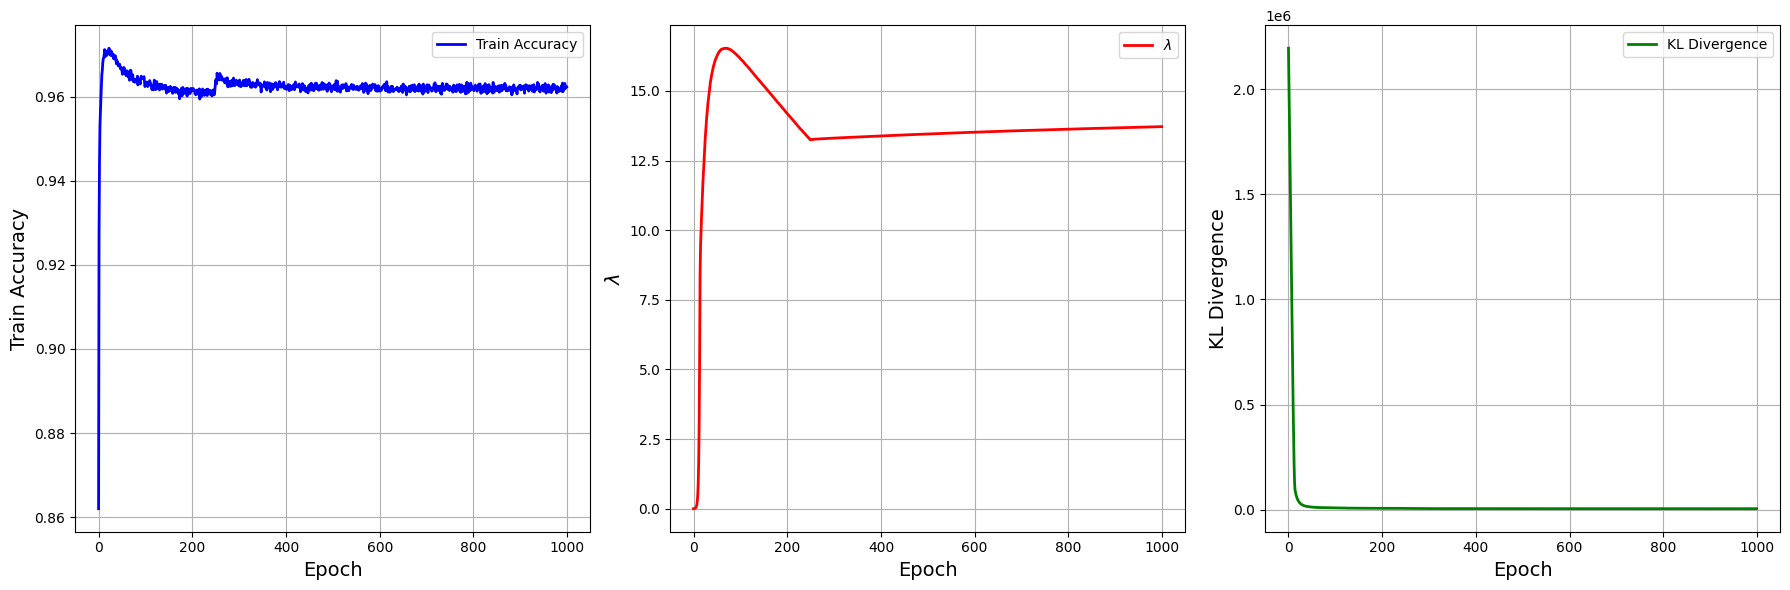

In [ ]:
import time as ts

# Number of epochs to match the paper (200,000 iterations)

epochs = 1000
initial_lr = 0.001  # First 150,000 iterations
lr_drop_epoch = 250  # Drop learning rate at 150,000 iterations
lr_factor = 0.1  # Reduce learning rate by lr_factor

# Initialize RMSprop optimizer (with alpha=0.9 as in the paper)
optimizer_sto = torch.optim.RMSprop([
    {'params': stoch_model.parameters(), 'lr': initial_lr, 'alpha': 0.9}, 
    {'params': pac_bound.log_lambda_, 'lr': initial_lr}
])

lambdas, train_accs, b_re_values, kl_values, bounds = [], [], [], [], []

for epoch in range(epochs):
    _ts = ts.perf_counter()

    # Drop learning rate after 250 epochs
    if epoch == lr_drop_epoch:
        for param_group in optimizer_sto.param_groups:
            param_group['lr'] *= lr_factor

    # Run one training epoch
    train_res = train_epoch(train_loader, stoch_model, pac_bound.train_bound, optimizer_sto)
    train_accs.append(train_res['stats']['accuracy'])
    
    # Compute PAC-Bayes metrics
    lambdas.append(torch.exp(pac_bound.log_lambda_).item())
    b_re_values.append(pac_bound.B_RE(stoch_model).item())

    stoch_model.eval()
    kl = pac_bound.kl(stoch_model).item()
    kl_values.append(kl)
    bounds.append(get_approx_bound(b_re_values[-1], train_accs[-1]))
    
    print(f"Epoch {epoch + 1} / {epochs}: Train Acc = {train_accs[-1] :.4f}, λ = {lambdas[-1] :.4f}, "
          f"Bound:{bounds[-1] :.4f}, B_RE = {b_re_values[-1] :.4f}, KL = {kl_values[-1] :.4f}, Time: {ts.perf_counter() - _ts :.2f}s")


# Plots
f, arr = plt.subplots(1, 3, figsize=(18, 6))

arr[0].plot(train_accs, lw=2, label="Train Accuracy", color="blue")
arr[0].set_ylabel("Train Accuracy", fontsize=14)
arr[0].set_xlabel("Epoch", fontsize=14)
arr[0].legend()
arr[0].grid()

arr[1].plot(lambdas, lw=2, label=r"$\lambda$", color="red")
arr[1].set_ylabel(r"$\lambda$", fontsize=14)
arr[1].set_xlabel("Epoch", fontsize=14)
arr[1].legend()
arr[1].grid()

# Plot KL Divergence
arr[2].plot(kl_values, lw=2, label="KL Divergence", color="green")
arr[2].set_ylabel("KL Divergence", fontsize=14)
arr[2].set_xlabel("Epoch", fontsize=14)
arr[2].legend()
arr[2].grid()

plt.tight_layout()
plt.show()

In [23]:
stoch_model

StochaNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): StochLinear()
    (2): ReLU()
    (3): StochLinear()
  )
)

In [24]:
torch.save(stoch_model.state_dict(), "stoch_model.pt")
# torch.save(pac_bound.log_lambda_, "lambda.pt")

# Multi Class

In [16]:
def training_pipeline_multi(epochs, model, train_loader, test_loader, optimizer, patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_train_tab = []
    loss_valid_tab = []
    best_val_loss = float("inf")
    best_model = None
    model.to(device)
    print("Module sélectionné pour l'entraînement :", device)
    epochs_no_improve = 0
    criterion = torch.nn.CrossEntropyLoss()  # Using CrossEntropyLoss for multi-class classification

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0
        
        for k, (image_train, label_train) in enumerate(train_loader):
            image_train, label_train = image_train.to(device), label_train.to(device).long()
            optimizer.zero_grad()
            output = model(image_train)  
            loss = criterion(output, label_train)
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            
            # Get predictions: max value index as the predicted class
            predictions = torch.argmax(output, dim=1)  # Predictions are the class with the highest logit
            total_train_correct += (predictions == label_train).sum().item()
            total_train_samples += label_train.size(0)
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train_samples
        loss_train_tab.append(avg_train_loss)
        
        model.eval()
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0
        with torch.no_grad():
            for k, (image_test, label_test) in enumerate(test_loader):
                image_test, label_test = image_test.to(device), label_test.to(device).long() 
                output = model(image_test)
                loss = criterion(output, label_test)
                total_val_loss += loss.item()
                
                # Get predictions: max value index as the predicted class
                predictions = torch.argmax(output, dim=1)  # Predictions are the class with the highest logit
                total_val_correct += (predictions == label_test).sum().item()
                total_val_samples += label_test.size(0)
        
        avg_val_loss = total_val_loss / len(test_loader)
        val_accuracy = total_val_correct / total_val_samples
        loss_valid_tab.append(avg_val_loss)
        
        print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = copy.deepcopy(model)  # Save the best model
            epochs_no_improve = 0  # Reset the counter
            print(f"A new best model has been found with validation loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {patience} epochs with no improvement.")
            break
        
        if (epoch + 1) % 10 == 0:
            plot_training_history(loss_train_tab, loss_valid_tab)
            
    plot_training_history(loss_train_tab, loss_valid_tab)
    return best_model, loss_valid_tab

Module sélectionné pour l'entraînement : cuda
Epoch 1/20 - Train Loss: 0.2634, Validation Loss: 0.1410, Train Acc: 0.9227, Val Acc: 0.9584
A new best model has been found with validation loss: 0.1410
Epoch 2/20 - Train Loss: 0.1154, Validation Loss: 0.0998, Train Acc: 0.9675, Val Acc: 0.9714
A new best model has been found with validation loss: 0.0998
Epoch 3/20 - Train Loss: 0.0787, Validation Loss: 0.0827, Train Acc: 0.9773, Val Acc: 0.9768
A new best model has been found with validation loss: 0.0827
Epoch 4/20 - Train Loss: 0.0576, Validation Loss: 0.0754, Train Acc: 0.9841, Val Acc: 0.9769
A new best model has been found with validation loss: 0.0754
Epoch 5/20 - Train Loss: 0.0449, Validation Loss: 0.0710, Train Acc: 0.9873, Val Acc: 0.9794
A new best model has been found with validation loss: 0.0710
Epoch 6/20 - Train Loss: 0.0348, Validation Loss: 0.0692, Train Acc: 0.9911, Val Acc: 0.9790
A new best model has been found with validation loss: 0.0692
Epoch 7/20 - Train Loss: 0.027

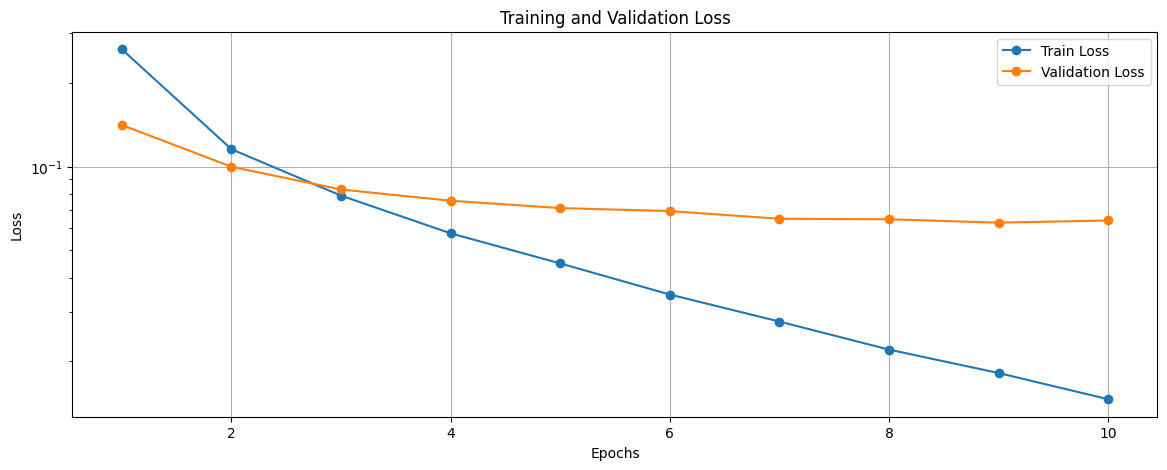

Epoch 11/20 - Train Loss: 0.0123, Validation Loss: 0.0597, Train Acc: 0.9985, Val Acc: 0.9820
A new best model has been found with validation loss: 0.0597
Epoch 12/20 - Train Loss: 0.0101, Validation Loss: 0.0622, Train Acc: 0.9991, Val Acc: 0.9809
Epoch 13/20 - Train Loss: 0.0087, Validation Loss: 0.0601, Train Acc: 0.9992, Val Acc: 0.9814
Epoch 14/20 - Train Loss: 0.0074, Validation Loss: 0.0601, Train Acc: 0.9995, Val Acc: 0.9815
Epoch 15/20 - Train Loss: 0.0064, Validation Loss: 0.0611, Train Acc: 0.9996, Val Acc: 0.9817
Epoch 16/20 - Train Loss: 0.0056, Validation Loss: 0.0608, Train Acc: 0.9997, Val Acc: 0.9814
Epoch 17/20 - Train Loss: 0.0049, Validation Loss: 0.0601, Train Acc: 0.9999, Val Acc: 0.9819
Epoch 18/20 - Train Loss: 0.0044, Validation Loss: 0.0614, Train Acc: 0.9999, Val Acc: 0.9822
Epoch 19/20 - Train Loss: 0.0040, Validation Loss: 0.0621, Train Acc: 0.9999, Val Acc: 0.9818
Epoch 20/20 - Train Loss: 0.0036, Validation Loss: 0.0620, Train Acc: 0.9999, Val Acc: 0.9818

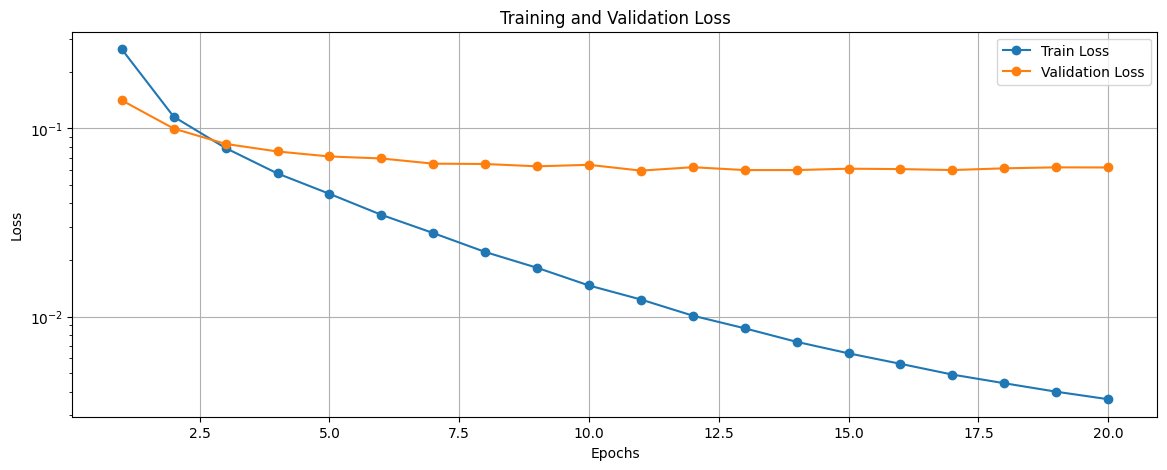

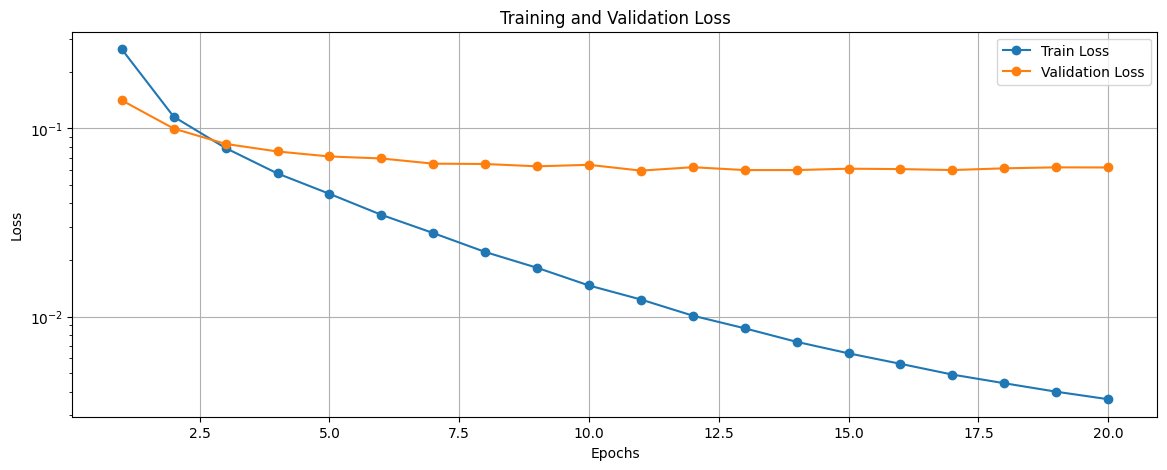

(MLP(
   (layers): Sequential(
     (0): Flatten(start_dim=1, end_dim=-1)
     (1): Linear(in_features=784, out_features=600, bias=True)
     (2): ReLU()
     (3): Linear(in_features=600, out_features=10, bias=True)
   )
 ),
 [0.1409823948238045,
  0.09982779533253051,
  0.0827346621605102,
  0.07541624446515925,
  0.07096446637937333,
  0.06924324786232319,
  0.06497842684824719,
  0.06471170547170914,
  0.06291313458437799,
  0.06406423101492692,
  0.05968337696242088,
  0.06222635890306265,
  0.060080282183917005,
  0.0600879273875762,
  0.06111172338314645,
  0.06080251168656105,
  0.06009792345996175,
  0.06137980547926418,
  0.062125997889888825,
  0.0620084763804698])

In [ ]:
model_multiclass = MLP(nb_nodes=600, nb_hidden_layers=1, classes=10).to(device)
optimizer_multi = torch.optim.SGD(model_multiclass.parameters(), lr=0.01, momentum=0.9)
best_model, loss_valid_tab = training_pipeline_multi(epochs=20, model=model_multiclass, train_loader=train_loader, test_loader=test_loader, optimizer=optimizer_multi, patience=patience)

In [83]:
torch.save(model_multiclass.state_dict(), "model_init_multiclass.pt")

In [20]:
def train_epoch(loader, model, loss_fn, optimizer, device=device):
    """
    Runs one training epoch.
    """
    model.train()
    running_loss = 0.0
    total_samples = 0
    total_train_samples = 0
    total_train_correct = 0
    acc = 0

    
    for i, (inputs, targets) in enumerate(loader):
    
        inputs = inputs.to(device)
        # targets = label_modif(targets)
        targets = targets.to(device).float()
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss, _, _ = loss_fn(model, inputs, targets)
        # print(loss)
        loss.backward()
        optimizer.step()
        
        batch_size = inputs.size(0)
        running_loss += loss.item() * batch_size
        total_samples += batch_size
        total_train_samples += batch_size
        predictions = torch.argmax(outputs, dim=1)
        total_train_correct += (predictions == targets).sum().item()

        total_train_samples += 1
    acc = acc / len(loader)
    avg_loss = running_loss / total_samples
    train_accuracy = total_train_correct / total_train_samples
    
    return {"loss": avg_loss, "stats": {'accuracy': train_accuracy}}


def eval_model(loader, model, loss_fn, device=device):
    """
    Evaluates the model on the given dataset.
    """
    model.eval()
    running_loss = 0.0
    total_samples = 0
    total_correct = 0
    acc = 0
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs = inputs.to(device)
            targets = targets.to(device).long()
            outputs = model(inputs)
            loss, _, _ = loss_fn(model, inputs, targets)
            batch_size = inputs.size(0)
            running_loss += loss.item() * batch_size
            total_samples += batch_size
            predictions = torch.argmax(outputs, dim=1)
            total_correct += (predictions == targets).sum().item()
        
        acc = acc / len(loader)
        avg_loss = running_loss / total_samples
        accuracy = total_correct / total_samples
    return {"loss": avg_loss, "stats": {'accuracy': accuracy}}

In [21]:
class PACBound:
    def __init__(self, prior_mean, lambda_init, likelihood_fn, num_data, delta=0.025, b=100, c=0.1):
        
        self.prior_mu = prior_mean.to(device)
        self.log_lambda_ = torch.tensor([math.log(lambda_init)],
                                   requires_grad=True, device=device)
        self.likelihood_fn = likelihood_fn
        self.num_data = torch.tensor([num_data], requires_grad=False, 
                                     dtype=float, device=device)
        self.delta = delta
        self.b = b
        self.c = c
        
    def kl(self, stoch_network):
        mu_net, sigma_net = self._get_mu_sigma(stoch_network.layers)
        prior_sigma = torch.ones_like(sigma_net, device=sigma_net.device) * self.prior_sigma.cuda()

        return self._kl_gaussians(mu_net, sigma_net, self.prior_mu, prior_sigma)

    
    # def train_bound(self, stoch_network, x, y):
    #     preds = stoch_network(x).flatten()
    #     acc = (preds * y > 0).float().mean()
    #     likelihood = self.likelihood_fn(preds, y)
    #     regularizer =  torch.sqrt(self.B_RE(stoch_network) / 2)
    #     # print(likelihood, regularizer)
    #     return likelihood + regularizer, preds, \
    #            {'accuracy': acc, 'regularizer': regularizer}
    
    def train_bound(self, stoch_network, x, y):
        # Forward pass through the stochastic network
        preds = stoch_network(x)  # This will be of shape (batch_size, num_classes)
        
        # Multi-class accuracy: get the index of the maximum output (i.e., predicted class)
        _, predicted_classes = torch.max(preds, dim=1)
        
        # Compute accuracy
        acc = (predicted_classes == y).float().mean()

        # Compute likelihood (CrossEntropyLoss is used)
        likelihood = self.likelihood_fn(preds, y.long())

        # Compute the regularizer term based on the B_RE bound
        regularizer = torch.sqrt(self.B_RE(stoch_network) / 2)

        return likelihood + regularizer, preds, {'accuracy': acc, 'regularizer': regularizer}
    
    def B_RE(self, stoch_network):
        kl = self.kl(stoch_network)
        return (kl + 
                2 * torch.log(torch.abs(self.b * (math.log(self.c) - self.log_lambda_))) + 
                math.log(math.pi**2 * self.num_data / (6 * self.delta))) / (self.num_data - 1)
        
    @property
    def prior_sigma(self):
        return 1 / torch.sqrt(torch.exp(self.log_lambda_))
        
    @staticmethod
    def _kl_gaussians(mu_1, sigma_1, mu_2, sigma_2):
        device = mu_1.device

        mu_1 = mu_1.to(device)
        mu_2 = mu_2.to(device)
        sigma_1 = sigma_1.to(device)
        sigma_2 = sigma_2.to(device)
        
        d = mu_1.numel()
        kl = 0.5 * (torch.sum(torch.log(sigma_2) - torch.log(sigma_1)) * 2 +
                    torch.sum(sigma_1**2 / sigma_2**2) +
                    torch.sum((mu_2 - mu_1)**2 / sigma_2**2) - d)
        return kl 
        
    @staticmethod
    def _get_mu_sigma(stoch_network):
        mu_net, sigma_net = [torch.cat(a) for a in 
                             zip(*[
                                  [torch.cat([layer.weight_mu.flatten(), layer.bias_mu.flatten()]),
                                  torch.cat([layer.weight_sigma.flatten(), layer.bias_sigma.flatten()])]
                                  for 
                                  layer in stoch_network if
                                  isinstance(layer, StochLinear)])
                            ]
        return mu_net, sigma_net

In [22]:
model_multiclass = MLP(nb_nodes=600, nb_hidden_layers=1, classes=10)
state_dict = torch.load("model_init_multiclass.pt")
model_multiclass.load_state_dict(state_dict)
model_multiclass.cuda()
crtierion = torch.nn.CrossEntropyLoss()
prior_mu = torch.cat([p.detach().flatten() for p in model_multiclass.layers.parameters()])
pac_bound = PACBound(prior_mu, lambda_init=1e-3, likelihood_fn=crtierion, num_data=len(train_dataset))

stoch_model_multi = StochaNN(nb_nodes=600, nb_hidden_layers=1, classes=10, isp_sigma=-2)
for stoch_layer, layer in zip(stoch_model_multi.layers, model_multiclass.layers):
    if isinstance(stoch_layer, StochLinear):
        stoch_layer.copy_weights(layer)
stoch_model_multi.cuda()

C:\Users\jadza\AppData\Local\Temp\ipykernel_23764\209511201.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load("model_init_multiclass.pt")


StochaNN(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): StochLinear()
    (2): ReLU()
    (3): StochLinear()
  )
)

**** Epoch 1 / 100: Test accuracy: 0.8847 ****
Epoch 1 / 100: Train Acc = 0.8093, λ = 0.0021, Bound:0.9990, B_RE = 37.0013, KL = 2220013.7500, Time: 12.09s


C:\Users\jadza\AppData\Local\Temp\ipykernel_23764\3884024255.py:4: RuntimeWarning: divide by zero encountered in scalar divide
  return q * math.log(q / p)+ (1 - q) * math.log((1 - q) / (1 - p))


Epoch 2 / 100: Train Acc = 0.8929, λ = 0.0038, Bound:0.9990, B_RE = 34.4695, KL = 2068107.5000, Time: 10.29s
Epoch 3 / 100: Train Acc = 0.9149, λ = 0.0069, Bound:0.9990, B_RE = 31.8036, KL = 1908160.5000, Time: 12.94s
Epoch 4 / 100: Train Acc = 0.9266, λ = 0.0127, Bound:0.9990, B_RE = 29.0499, KL = 1742940.0000, Time: 35.33s
Epoch 5 / 100: Train Acc = 0.9362, λ = 0.0232, Bound:0.9990, B_RE = 26.2693, KL = 1576106.2500, Time: 34.10s
Epoch 6 / 100: Train Acc = 0.9425, λ = 0.0425, Bound:0.9990, B_RE = 23.4411, KL = 1406418.3750, Time: 35.27s
Epoch 7 / 100: Train Acc = 0.9467, λ = 0.0778, Bound:0.9990, B_RE = 20.6118, KL = 1236665.0000, Time: 36.08s
Epoch 8 / 100: Train Acc = 0.9495, λ = 0.1428, Bound:0.9990, B_RE = 17.8019, KL = 1068073.5000, Time: 34.92s
Epoch 9 / 100: Train Acc = 0.9515, λ = 0.2622, Bound:0.9990, B_RE = 14.9769, KL = 898571.8750, Time: 32.77s
Epoch 10 / 100: Train Acc = 0.9535, λ = 0.4817, Bound:0.9990, B_RE = 12.2304, KL = 733787.9375, Time: 36.03s
Epoch 11 / 100: Trai

IndexError: index 3 is out of bounds for axis 0 with size 3

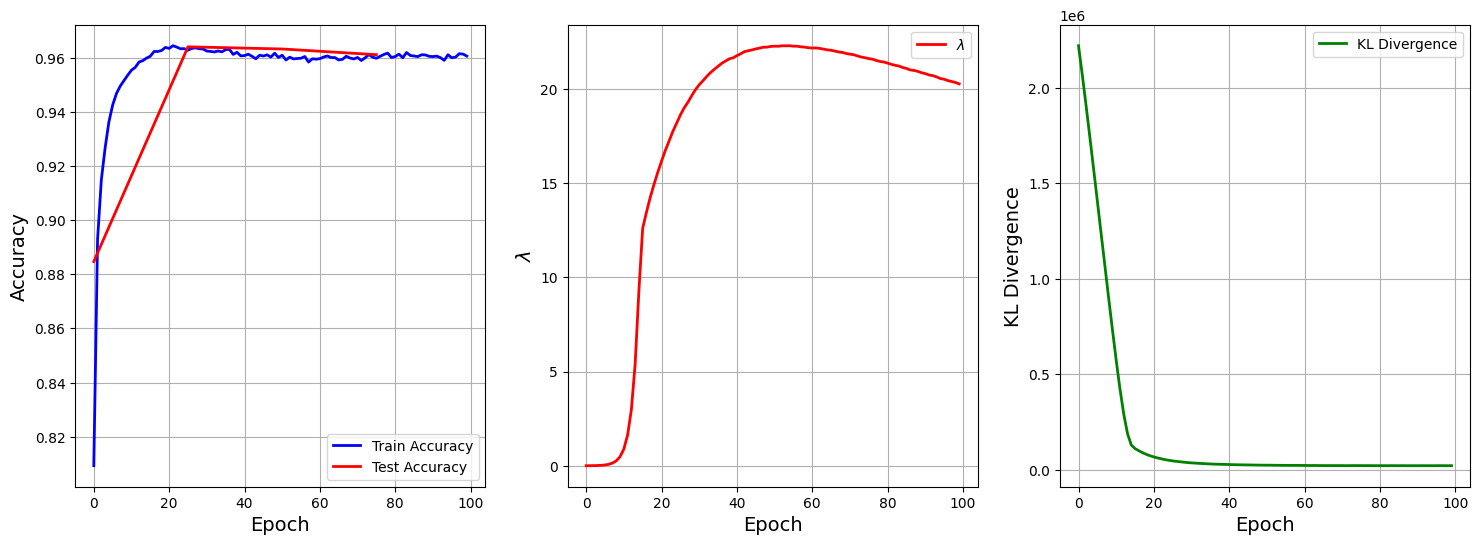

In [ ]:
import time as ts

# Number of epochs to match the paper (200,000 iterations)

epochs = 100
initial_lr = 0.001  # First 150,000 iterations
lr_drop_epoch = 250  # Drop learning rate at 150,000 iterations
lr_factor = 0.1  # Reduce learning rate by lr_factor
eval_freq = 25

# Initialize RMSprop optimizer (with alpha=0.9 as in the paper)
optimizer_sto = torch.optim.RMSprop([
    {'params': stoch_model_multi.parameters(), 'lr': initial_lr, 'alpha': 0.9}, 
    {'params': pac_bound.log_lambda_, 'lr': initial_lr}
])

lambdas, train_accs, test_accs, b_re_values, kl_values, bounds = [], [], [], [], [], []
idx = []

for epoch in range(epochs):
    _ts = ts.perf_counter()

    # Drop learning rate after 250 epochs
    if epoch == lr_drop_epoch:
        for param_group in optimizer_sto.param_groups:
            param_group['lr'] *= lr_factor

    # Run one training epoch
    train_res = train_epoch(train_loader, stoch_model_multi, pac_bound.train_bound, optimizer_sto)
    if epoch % eval_freq == 0:
        idx.append(epoch)
        test_res = eval_model(test_loader, stoch_model_multi, pac_bound.train_bound)
        test_accs.append(test_res['stats']['accuracy'])
        print(f'**** Epoch {epoch + 1} / {epochs}: Test accuracy: {test_accs[-1]} ****')
    train_accs.append(train_res['stats']['accuracy'])
    
    # Compute PAC-Bayes metrics
    lambdas.append(torch.exp(pac_bound.log_lambda_).item())
    b_re_values.append(pac_bound.B_RE(stoch_model_multi).item())

    stoch_model_multi.eval()
    kl = pac_bound.kl(stoch_model_multi).item()
    kl_values.append(kl)
    bounds.append(get_approx_bound(b_re_values[-1], train_accs[-1]))
    
    print(f"Epoch {epoch + 1} / {epochs}: Train Acc = {train_accs[-1] :.4f}, λ = {lambdas[-1] :.4f}, "
          f"Bound:{bounds[-1] :.4f}, B_RE = {b_re_values[-1] :.4f}, KL = {kl_values[-1] :.4f}, Time: {ts.perf_counter() - _ts :.2f}s")


# Plots
f, arr = plt.subplots(1, 4, figsize=(18, 6))

arr[0].plot(train_accs, lw=2, label="Train Accuracy", color="blue")
arr[0].plot(idx, test_accs, lw=2, label="Test Accuracy", color="red")
arr[0].set_ylabel("Accuracy", fontsize=14)
arr[0].set_xlabel("Epoch", fontsize=14)
arr[0].legend()
arr[0].grid()

arr[1].plot(lambdas, lw=2, label=r"$\lambda$", color="red")
arr[1].set_ylabel(r"$\lambda$", fontsize=14)
arr[1].set_xlabel("Epoch", fontsize=14)
arr[1].legend()
arr[1].grid()

# Plot KL Divergence
arr[2].plot(kl_values, lw=2, label="KL Divergence", color="green")
arr[2].set_ylabel("KL Divergence", fontsize=14)
arr[2].set_xlabel("Epoch", fontsize=14)
arr[2].legend()
arr[2].grid()

# Plot Bound
arr[3].plot(bounds, lw=2, label="Bound", color="green")
arr[3].set_ylabel("Bound", fontsize=14)
arr[3].set_xlabel("Epoch", fontsize=14)
arr[3].legend()
arr[3].grid()

plt.tight_layout()
plt.show()

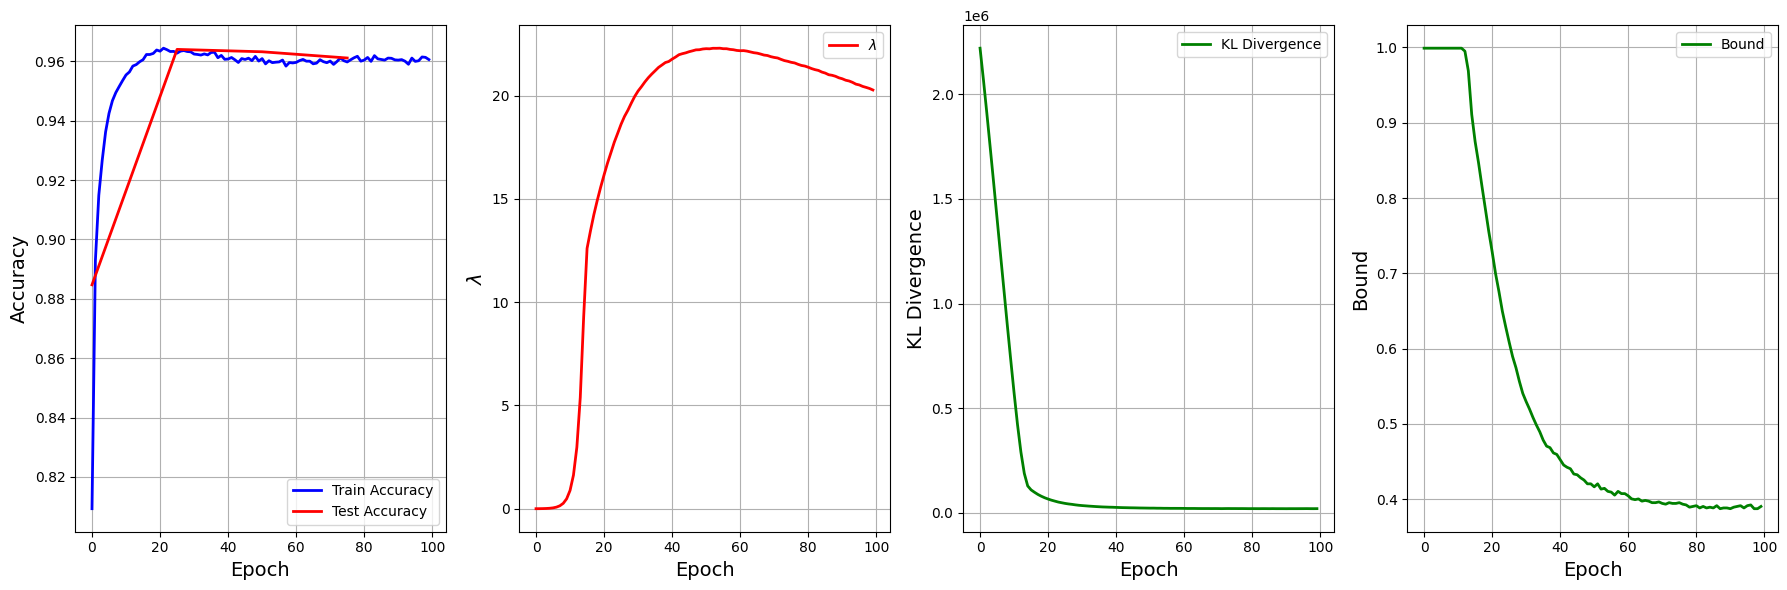

In [24]:
# Plots
f, arr = plt.subplots(1, 4, figsize=(18, 6))

arr[0].plot(train_accs, lw=2, label="Train Accuracy", color="blue")
arr[0].plot(idx, test_accs, lw=2, label="Test Accuracy", color="red")
arr[0].set_ylabel("Accuracy", fontsize=14)
arr[0].set_xlabel("Epoch", fontsize=14)
arr[0].legend()
arr[0].grid()

arr[1].plot(lambdas, lw=2, label=r"$\lambda$", color="red")
arr[1].set_ylabel(r"$\lambda$", fontsize=14)
arr[1].set_xlabel("Epoch", fontsize=14)
arr[1].legend()
arr[1].grid()

# Plot KL Divergence
arr[2].plot(kl_values, lw=2, label="KL Divergence", color="green")
arr[2].set_ylabel("KL Divergence", fontsize=14)
arr[2].set_xlabel("Epoch", fontsize=14)
arr[2].legend()
arr[2].grid()

# Plot Bound
arr[3].plot(bounds, lw=2, label="Bound", color="green")
arr[3].set_ylabel("Bound", fontsize=14)
arr[3].set_xlabel("Epoch", fontsize=14)
arr[3].legend()
arr[3].grid()

plt.tight_layout()
plt.show()